In [14]:
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout, RepeatVector, TimeDistributed, Bidirectional
import numpy as np


In [15]:
data = pd.read_csv('lead1.0-small.csv')

In [16]:
data.head()

,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01 00:00:00,NaN,0
1,32,2016-01-01 00:00:00,NaN,0
2,41,2016-01-01 00:00:00,NaN,0
3,55,2016-01-01 00:00:00,NaN,0
4,69,2016-01-01 00:00:00,NaN,0


In [17]:
df = data.loc[data['building_id']==653]

In [18]:
df.head()

,building_id,timestamp,meter_reading,anomaly
57,653,2016-01-01 00:00:00,563.787,0
257,653,2016-01-01 01:00:00,562.581,0
455,653,2016-01-01 02:00:00,558.533,0
654,653,2016-01-01 03:00:00,560.720,0
853,653,2016-01-01 04:00:00,560.187,0


In [19]:
df[df['anomaly']==1].shape

(250, 4)

In [20]:
df['meter_reading'].isnull().sum()

np.int64(0)

In [1]:
fig =go.Figure()
fig.add_trace(go.Scatter(x=df['timestamp'],y=df['meter_reading']))
fig.update_layout(showlegend=True, title='meter reading vs date &time')
fig.show()

NameError: name 'go' is not defined

In [22]:
df= df[['timestamp','meter_reading']]
df.head()

,timestamp,meter_reading
57,2016-01-01 00:00:00,563.787
257,2016-01-01 01:00:00,562.581
455,2016-01-01 02:00:00,558.533
654,2016-01-01 03:00:00,560.720
853,2016-01-01 04:00:00,560.187


<h4>2.TRAIN TEST SPLIT</h4>

In [23]:
train = df.loc[df['timestamp']<='2016-07-15']
test = df.loc[df['timestamp']>'2016-07-15']
train.shape , test.shape

((4681, 2), (4080, 2))

In [24]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['meter_reading']).reshape(-1,1))

train['meter_reading'] = scaler.transform(np.array(train['meter_reading']).reshape(-1,1))
test['meter_reading'] = scaler.transform(np.array(test['meter_reading']).reshape(-1,1))


C:\Users\Admin\AppData\Local\Temp\ipykernel_10968\4241436710.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\AppData\Local\Temp\ipykernel_10968\4241436710.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



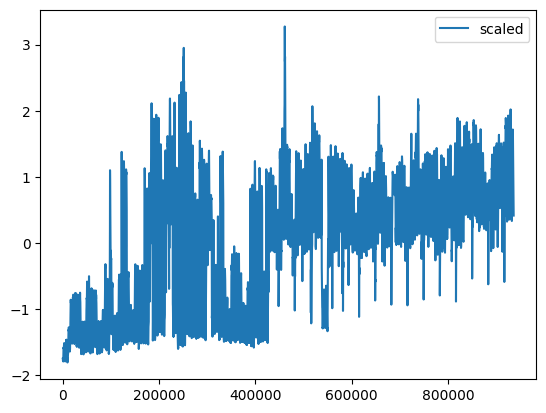

In [25]:
#visualizing scaled data
plt.plot(train['meter_reading'],label='scaled')
plt.legend()
plt.show()

In [26]:
#creating sequence

TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['meter_reading']], train['meter_reading'])
X_test, y_test = create_sequences(test[['meter_reading']], test['meter_reading'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (4651, 30, 1)
Testing input shape:  (4050, 30, 1)


In [27]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

In [28]:
model = Sequential()
# Encoder
model.add(LSTM(128, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32, activation='relu', return_sequences=False))

# Bottleneck
model.add(RepeatVector(X_train.shape[1]))

# Decoder
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(X_train.shape[2])))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss=tf.keras.losses.Huber())


d:\ALL PROJECTS\17\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [29]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')],
                    shuffle=False)

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.5708 - val_loss: 0.4049
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.6276 - val_loss: 0.3945
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.6152 - val_loss: 0.3592
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.5978 - val_loss: 0.3275
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.5106 - val_loss: 0.2737
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.3649 - val_loss: 0.2322
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.3184 - val_loss: 0.2087
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2956 - val_loss: 0.1952
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2798 - val_loss: 0.1863
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.2667 - val_loss: 0.1798
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.2561 - val_loss: 0.1752
Epoch 12/100
131/131 ━━━━━━━━━

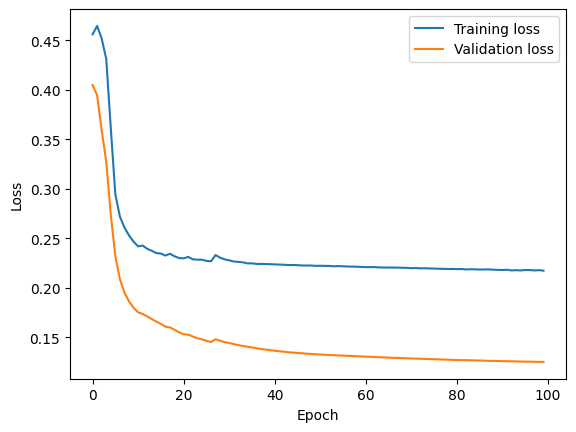

In [30]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_absolute_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_absolute_loss, bins=50)
plt.xlabel('Train Hubber LOSS loss')
plt.ylabel('Number of Samples')

# Set reconstruction error threshold
threshold = np.percentile(train_absolute_loss, 90)


print('Reconstruction error threshold:',threshold)

<h4><b>PREDICTING ANOMALIES ON TEST DATASET</b></h4>

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Text(0, 0.5, 'Number of samples')

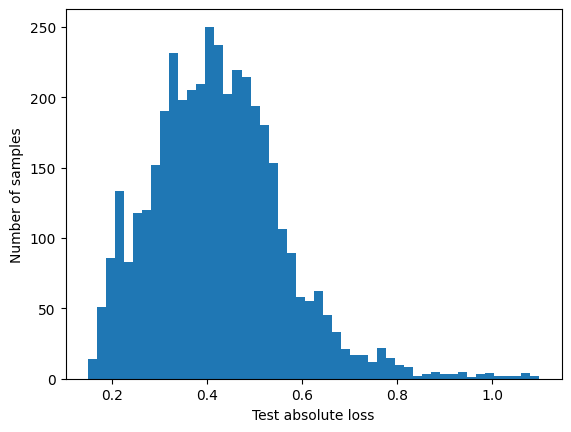

In [32]:
X_test_pred = model.predict(X_test, verbose=1)
test_absolute_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_absolute_loss, bins=50)
plt.xlabel('Test absolute loss')
plt.ylabel('Number of samples')

In [42]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_absolute_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [43]:
anomaly_df.head()

,timestamp,meter_reading,loss,threshold,anomaly
942979,2016-07-16 06:00:00,0.469053,0.359731,0.894236,False
943178,2016-07-16 07:00:00,0.527663,0.352293,0.894236,False
943377,2016-07-16 08:00:00,0.618861,0.344299,0.894236,False
943576,2016-07-16 09:00:00,0.679234,0.333618,0.894236,False
943775,2016-07-16 10:00:00,0.827165,0.325704,0.894236,False


In [44]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [45]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,timestamp,meter_reading,loss,threshold,anomaly
1255617,2016-09-19 16:00:00,2.547859,0.942584,0.894236,True
1255816,2016-09-19 17:00:00,2.238433,0.988085,0.894236,True
1256015,2016-09-19 18:00:00,1.931258,1.003130,0.894236,True
1256214,2016-09-19 19:00:00,1.443660,1.000465,0.894236,True
1256413,2016-09-19 20:00:00,1.215785,0.974921,0.894236,True


In [46]:
fig = go.Figure()

# Reshape to 2D before applying inverse transform
readings = scaler.inverse_transform(anomaly_df[['meter_reading']])  # Double brackets to keep it 2D
anomaly_readings = scaler.inverse_transform(anomalies[['meter_reading']])

fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=readings.flatten(), name='readings'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=anomaly_readings.flatten(), mode='markers', name='Anomaly'))


fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [37]:
anomaly_df = pd.DataFrame(train[TIME_STEPS:])
anomaly_df['loss'] = train_absolute_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [38]:
anomaly_df.head()

,timestamp,meter_reading,loss,threshold,anomaly
6026,2016-01-02 06:00:00,-1.701021,0.477484,0.894236,False
6225,2016-01-02 07:00:00,-1.668968,0.476235,0.894236,False
6424,2016-01-02 08:00:00,-1.575325,0.474064,0.894236,False
6623,2016-01-02 09:00:00,-1.517407,0.469550,0.894236,False
6822,2016-01-02 10:00:00,-1.507317,0.463894,0.894236,False


In [39]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.shape

(465, 5)

In [41]:
fig = go.Figure()

# Reshape to 2D before applying inverse transform
readings = scaler.inverse_transform(anomaly_df[['meter_reading']])  # Double brackets to keep it 2D
anomaly_readings = scaler.inverse_transform(anomalies[['meter_reading']])

fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=readings.flatten(), name='readings'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=anomaly_readings.flatten(), mode='markers', name='Anomaly'))


fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()
